In [1]:
! pip install pandas matplotlib seaborn numpy scikit-learn statsmodels


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Load data and group by day

In [2]:
import pandas as pd
import os
from datetime import datetime

def process_aemo_data():
    """
    Process AEMO data files to group by state and date, summing TOTALDEMAND values.
    """
    # Base directory containing AEMO data
    base_dir = "../../data/raw/aemo_data_2018_2025"

    # List to store all processed data
    all_data = []
    
    # Get all state directories
    state_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    print(f"Found {len(state_dirs)} state directories: {state_dirs}")
    
    # Process each state directory
    for state_dir in state_dirs:
        state_path = os.path.join(base_dir, state_dir)
        
        # Extract state name (remove the '1' suffix if present)
        state = state_dir.replace('1', '') if state_dir.endswith('1') else state_dir
        
        print(f"Processing state: {state}")
        
        # Get all CSV files in the state directory
        csv_files = [f for f in os.listdir(state_path) if f.endswith('.csv')]
        
        for csv_file in csv_files:
            file_path = os.path.join(state_path, csv_file)
            
            try:
                # Read CSV file
                df = pd.read_csv(file_path)
                
                # Check if required columns exist
                if 'SETTLEMENTDATE' not in df.columns or 'TOTALDEMAND' not in df.columns:
                    print(f"  Skipping {csv_file}: Missing required columns")
                    continue
                
                # Convert SETTLEMENTDATE to datetime and extract date
                df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
                df['DATE'] = df['SETTLEMENTDATE'].dt.date
                
                # Group by date and sum TOTALDEMAND
                daily_totals = df.groupby('DATE')['TOTALDEMAND'].sum().reset_index()
                
                # Add state column
                daily_totals['STATE'] = state
                
                # Reorder columns
                daily_totals = daily_totals[['STATE', 'DATE', 'TOTALDEMAND']]
                
                all_data.append(daily_totals)
                
                print(f"  ✓ Processed {csv_file}: {len(daily_totals)} daily records")
                
            except Exception as e:
                print(f"  ✗ Error processing {csv_file}: {e}")
                continue
    
    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Group by state and date to handle any duplicates
        final_df = combined_df.groupby(['STATE', 'DATE'])['TOTALDEMAND'].sum().reset_index()
        
        # Sort by state and date
        final_df = final_df.sort_values(['STATE', 'DATE']).reset_index(drop=True)
        
        # Format the output
        final_df['TOTALDEMAND'] = final_df['TOTALDEMAND'].round(2)
        
        print(f"\n✓ Successfully processed {len(final_df)} state-date combinations")
        print(f"States included: {sorted(final_df['STATE'].unique())}")
        print(f"Date range: {final_df['DATE'].min()} to {final_df['DATE'].max()}")
        
        # Display first few rows as example
        print("\nFirst 10 rows:")
        print(final_df.head(10))
        
        return final_df
    else:
        print("No data was processed successfully")
        return None

# Process the AEMO data
aemo_grouped_data = process_aemo_data()


Found 5 state directories: ['TAS1', 'SA1', 'VIC1', 'NSW1', 'QLD1']
Processing state: TAS
  ✓ Processed PRICE_AND_DEMAND_202103_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_202102_TAS1.csv: 29 daily records
  ✓ Processed PRICE_AND_DEMAND_202312_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_201811_TAS1.csv: 31 daily records
  ✓ Processed PRICE_AND_DEMAND_201810_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_202001_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_202109_TAS1.csv: 31 daily records
  ✓ Processed PRICE_AND_DEMAND_202108_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_202210_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_202211_TAS1.csv: 31 daily records
  ✓ Processed PRICE_AND_DEMAND_201912_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_202501_TAS1.csv: 32 daily records
  ✓ Processed PRICE_AND_DEMAND_202409_TAS1.csv: 31 daily records
  ✓ Processed PRICE_AND_DEMAND_202408_TAS1.csv: 32 daily records
 

In [3]:
aemo_grouped_data

,STATE,DATE,TOTALDEMAND
0,NSW,2018-01-01,346532.75
1,NSW,2018-01-02,378965.84
2,NSW,2018-01-03,360065.93
3,NSW,2018-01-04,362772.07
4,NSW,2018-01-05,385022.79
...,...,...,...
13969,VIC,2025-08-28,1584817.80
13970,VIC,2025-08-29,1713402.10
13971,VIC,2025-08-30,1513254.15
13972,VIC,2025-08-31,1433502.20


In [4]:
# Load and join weather data with AEMO data
import pandas as pd

# Load weather data
weather_file = '../../data/weather/avg_weather_20180101_20250911.csv'
try:
    weather_data = pd.read_csv(weather_file)
    print(f"✓ Loaded weather data: {len(weather_data)} records")
    print(f"Weather data columns: {list(weather_data.columns)}")
    print(f"Weather data date range: {weather_data['YYYY-MM-DD'].min()} to {weather_data['YYYY-MM-DD'].max()}")
    print(f"Weather data states: {sorted(weather_data['state'].unique())}")
    
    # Convert date columns to datetime for proper joining
    weather_data['date'] = pd.to_datetime(weather_data['YYYY-MM-DD'])
    aemo_grouped_data['DATE'] = pd.to_datetime(aemo_grouped_data['DATE'])
    
    # Join AEMO data with weather data
    # Match on date and state (AEMO uses 'STATE', weather uses 'state')
    merged_data = pd.merge(
        aemo_grouped_data, 
        weather_data, 
        left_on=['DATE', 'STATE'], 
        right_on=['date', 'state'], 
        how='inner'
    )
    
    # Drop duplicate date and state columns
    merged_data = merged_data.drop(['date', 'state', 'YYYY-MM-DD'], axis=1)
    
    print(f"\n✓ Successfully merged data: {len(merged_data)} records")
    print(f"Merged data columns: {list(merged_data.columns)}")
    print(f"States in merged data: {sorted(merged_data['STATE'].unique())}")
    
    # Display first few rows
    print("\nFirst 5 rows of merged data:")
    print(merged_data.head())
    
except FileNotFoundError:
    print(f"✗ Weather file not found: {weather_file}")
    merged_data = None
except Exception as e:
    print(f"✗ Error loading/merging weather data: {e}")
    merged_data = None


✓ Loaded weather data: 14055 records
Weather data columns: ['state', 'YYYY-MM-DD', 'daily_rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
Weather data date range: 2018-01-01 to 2025-09-11
Weather data states: ['NSW', 'QLD', 'SA', 'TAS', 'VIC']

✓ Successfully merged data: 13974 records
Merged data columns: ['STATE', 'DATE', 'TOTALDEMAND', 'daily_rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
States in merged data: ['NSW', 'QLD', 'SA', 'TAS', 'VIC']

First 5 rows of merged data:
  STATE       DATE  TOTALDEMAND  daily_rain  max_temp  min_temp  radiation  \
0   NSW 2018-01-01    346532.75        0.48     30.72     16.57      29.07   
1   NSW 2018-01-02    378965.84        1.15     29.93     16.26      24.79   
2   NSW 2018-01-03    360065.93        4.55     27.61     15.18      25.36   
3   NSW 2018-01-04    362772.07        0.41     29.14     15.08      27.84   
4   NSW 2018-01-05    385022.79        0.06     32.24     15.08      30.42   

   rh_tmax 

# Group data by month

In [10]:
import pandas as pd

if merged_data is not None:
    # Ensure datetime
    merged_data["DATE"] = pd.to_datetime(merged_data["DATE"])

    # Cutoff date for 5-min settlement
    cutoff = pd.to_datetime("2021-10-01")

    # Apply conversion to MWh
    merged_data["MWh"] = merged_data.apply(
        lambda row: row["TOTALDEMAND"] * 0.5 if row["DATE"] < cutoff 
                    else row["TOTALDEMAND"] * (5/60),
        axis=1
    )

    # Extract year-month for grouping
    merged_data["year_month"] = merged_data["DATE"].dt.to_period("M")

    # Define aggregation functions
    agg_functions = {
        "MWh": "sum",          # Sum converted demand across the month
        "daily_rain": "mean",
        "max_temp": "mean",
        "min_temp": "mean",
        "radiation": "mean",
        "rh_tmax": "mean",
        "rh_tmin": "mean"
    }

    # Group by state + year_month
    monthly_data = (
        merged_data.groupby(["STATE", "year_month"])
        .agg(agg_functions)
        .reset_index()
    )

    # Convert year_month back to datetime
    monthly_data["DATE"] = monthly_data["year_month"].dt.to_timestamp()
    monthly_data = monthly_data.drop("year_month", axis=1)

    # Rename MWh column to make clear it’s monthly
    monthly_data = monthly_data.rename(columns={"MWh": "TOTALDEMAND"})

    # Reorder columns
    cols = ["STATE", "DATE"] + [col for col in monthly_data.columns if col not in ["STATE", "DATE"]]
    monthly_data = monthly_data[cols]

    print(f"✓ Successfully grouped data by state and month: {len(monthly_data)} records")
    print(f"Monthly data columns: {list(monthly_data.columns)}")
    print(f"Date range: {monthly_data['DATE'].min()} to {monthly_data['DATE'].max()}")
    print(f"States: {sorted(monthly_data['STATE'].unique())}")

    # Show preview
    print("\nFirst 10 rows of monthly grouped data:")
    print(monthly_data.head(10))

else:
    print("✗ Cannot group data - merged_data is None")
    monthly_data = None


✓ Successfully grouped data by state and month: 465 records
Monthly data columns: ['STATE', 'DATE', 'TOTALDEMAND', 'daily_rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
Date range: 2018-01-01 00:00:00 to 2025-09-01 00:00:00
States: ['NSW', 'QLD', 'SA', 'TAS', 'VIC']

First 10 rows of monthly grouped data:
  STATE       DATE  TOTALDEMAND  daily_rain   max_temp   min_temp  radiation  \
0   NSW 2018-01-01  6219977.770    1.550968  31.633548  17.253548  24.767742   
1   NSW 2018-02-01  5521163.395    2.398929  29.710000  16.009286  21.632500   
2   NSW 2018-03-01  5812928.960    1.904839  27.756774  14.464839  18.177419   
3   NSW 2018-04-01  5431874.065    0.925667  25.871333  12.072333  14.829333   
4   NSW 2018-05-01  5874759.805    0.749677  19.298710   6.134839  11.416129   
5   NSW 2018-06-01  6300361.280    1.910667  15.373333   4.397667   9.467000   
6   NSW 2018-07-01  6452774.755    0.579032  16.159032   2.633871  11.145806   
7   NSW 2018-08-01  6237326.250   

# Visualize data by state and month

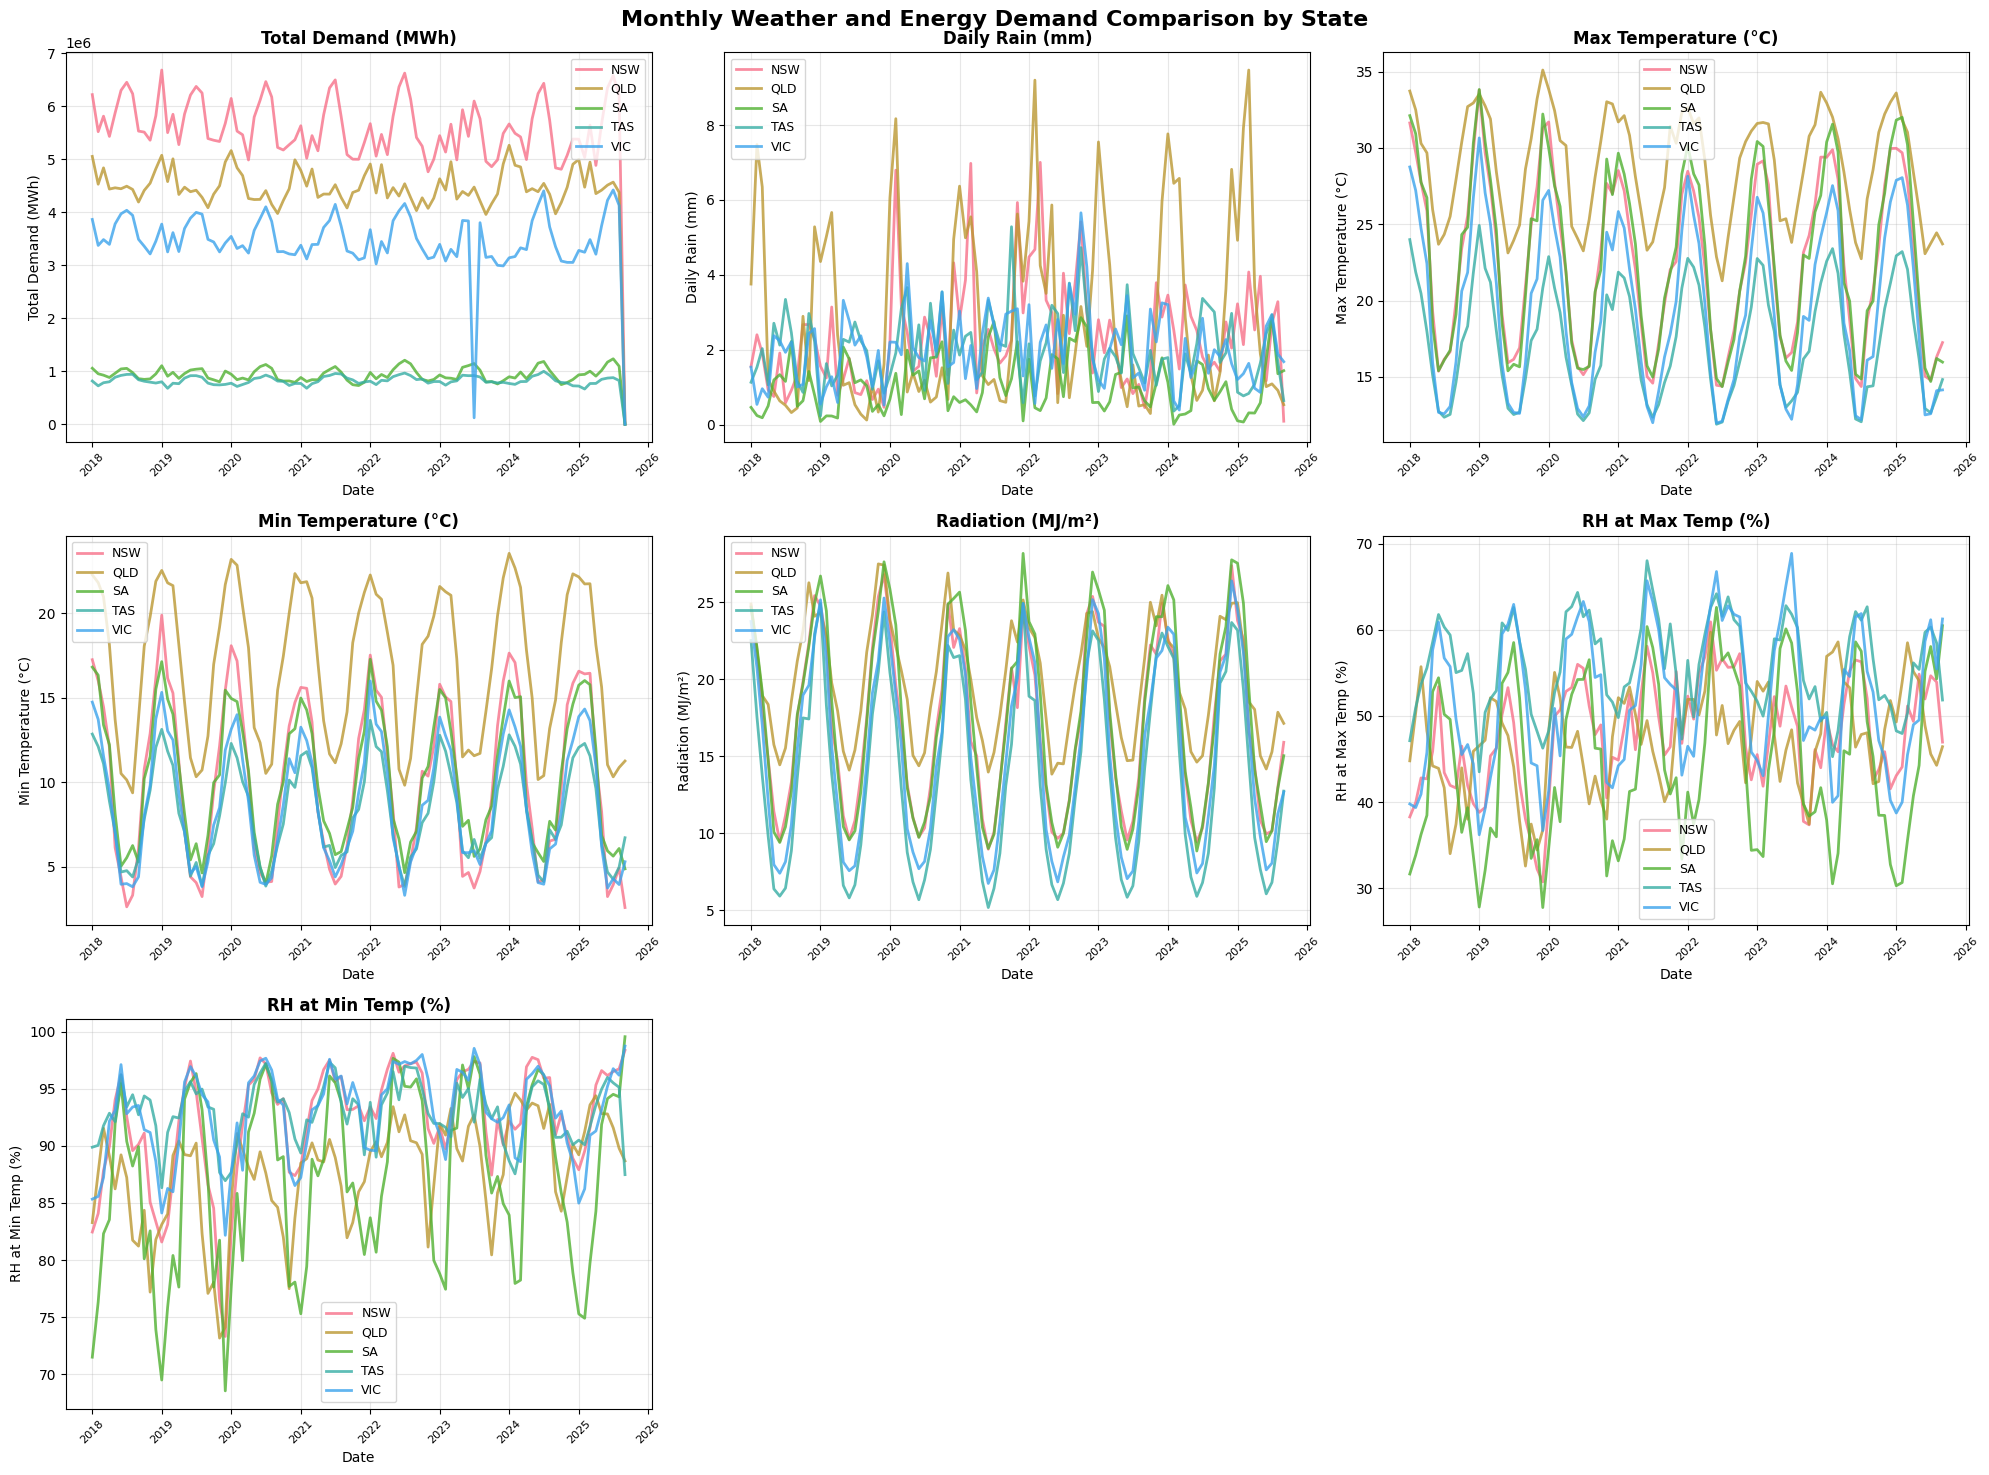

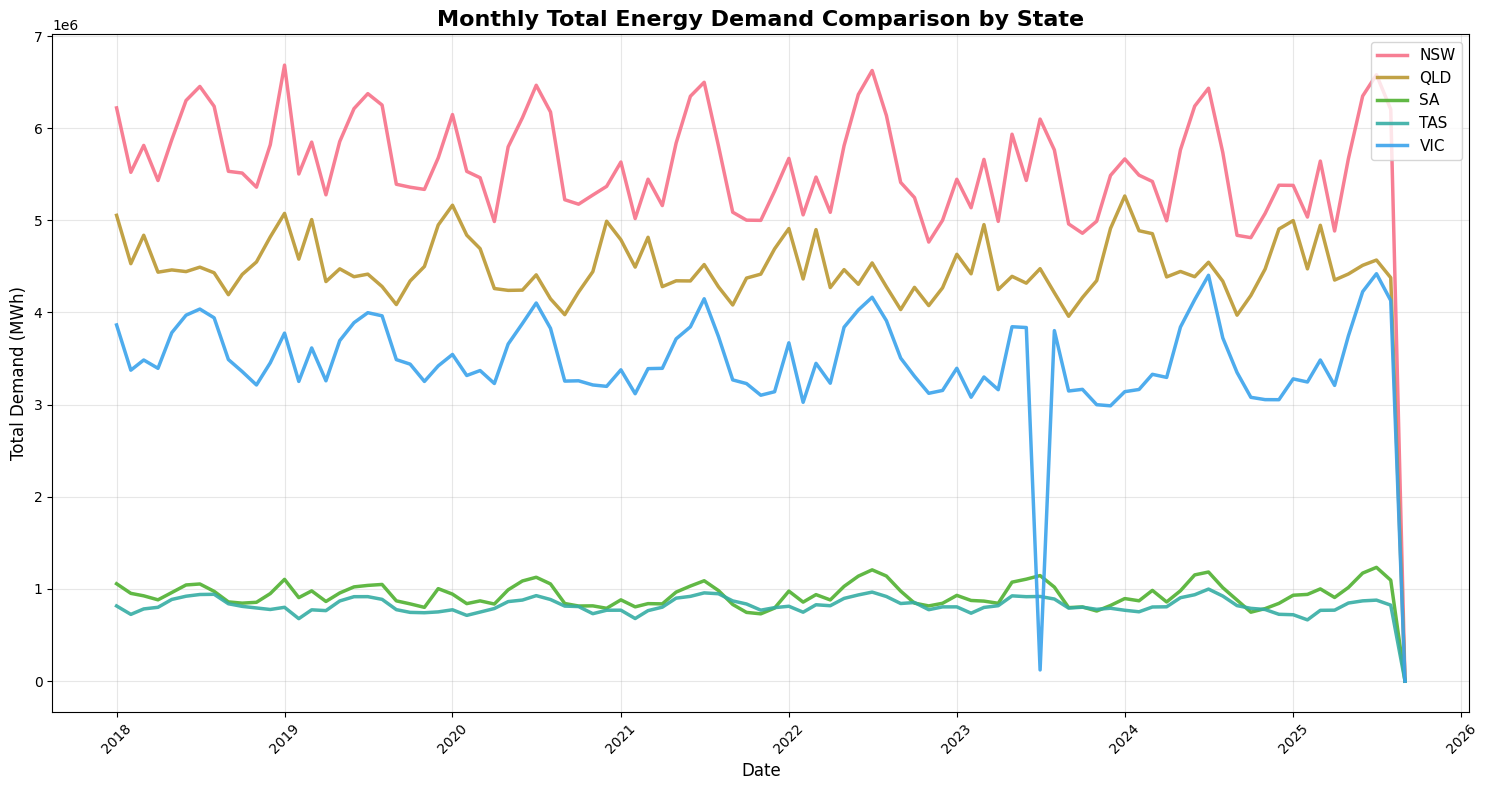


SUMMARY STATISTICS BY STATE


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

if monthly_data is not None:
    # Create a comprehensive visualization of all criteria by state
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Monthly Weather and Energy Demand Comparison by State', fontsize=16, fontweight='bold')
    
    # List of criteria to plot (excluding STATE and DATE)
    criteria = ['TOTALDEMAND', 'daily_rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
    
    # Define units for y-axis labels
    units = {
        'TOTALDEMAND': 'Total Demand (MWh)',
        'daily_rain': 'Daily Rain (mm)',
        'max_temp': 'Max Temperature (°C)',
        'min_temp': 'Min Temperature (°C)', 
        'radiation': 'Radiation (MJ/m²)',
        'rh_tmax': 'RH at Max Temp (%)',
        'rh_tmin': 'RH at Min Temp (%)'
    }
    
    # Plot each criterion
    for i, criterion in enumerate(criteria):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Plot line for each state
        for state in sorted(monthly_data['STATE'].unique()):
            state_data = monthly_data[monthly_data['STATE'] == state].sort_values('DATE')
            ax.plot(state_data['DATE'], state_data[criterion], linewidth=2, label=state, alpha=0.8)
        
        ax.set_title(f'{units[criterion]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel(units[criterion], fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Format x-axis to show fewer ticks for better readability
        ax.tick_params(axis='x', labelsize=8)
        
    # Remove empty subplot (we have 7 criteria but 9 subplots)
    fig.delaxes(axes[2, 1])
    fig.delaxes(axes[2, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Create a separate detailed plot for Total Demand comparison
    plt.figure(figsize=(15, 8))
    for state in sorted(monthly_data['STATE'].unique()):
        state_data = monthly_data[monthly_data['STATE'] == state].sort_values('DATE')
        plt.plot(state_data['DATE'], state_data['TOTALDEMAND'], linewidth=2.5, label=state, alpha=0.9)
    
    plt.title('Monthly Total Energy Demand Comparison by State', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Demand (MWh)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("\n" + "="*80)
    print("SUMMARY STATISTICS BY STATE")
    print("="*80)
    
    summary_stats = monthly_data.groupby('STATE').agg({
        'TOTALDEMAND': ['mean', 'std', 'min', 'max'],
        'daily_rain': ['mean', 'std'],
        'max_temp': ['mean', 'std'],
        'min_temp': ['mean', 'std'],
        'radiation': ['mean', 'std'],
        'rh_tmax': ['mean', 'std'],
        'rh_tmin': ['mean', 'std']
    }).round(2)
        
else:
    print("✗ Cannot create visualizations - monthly_data is None")


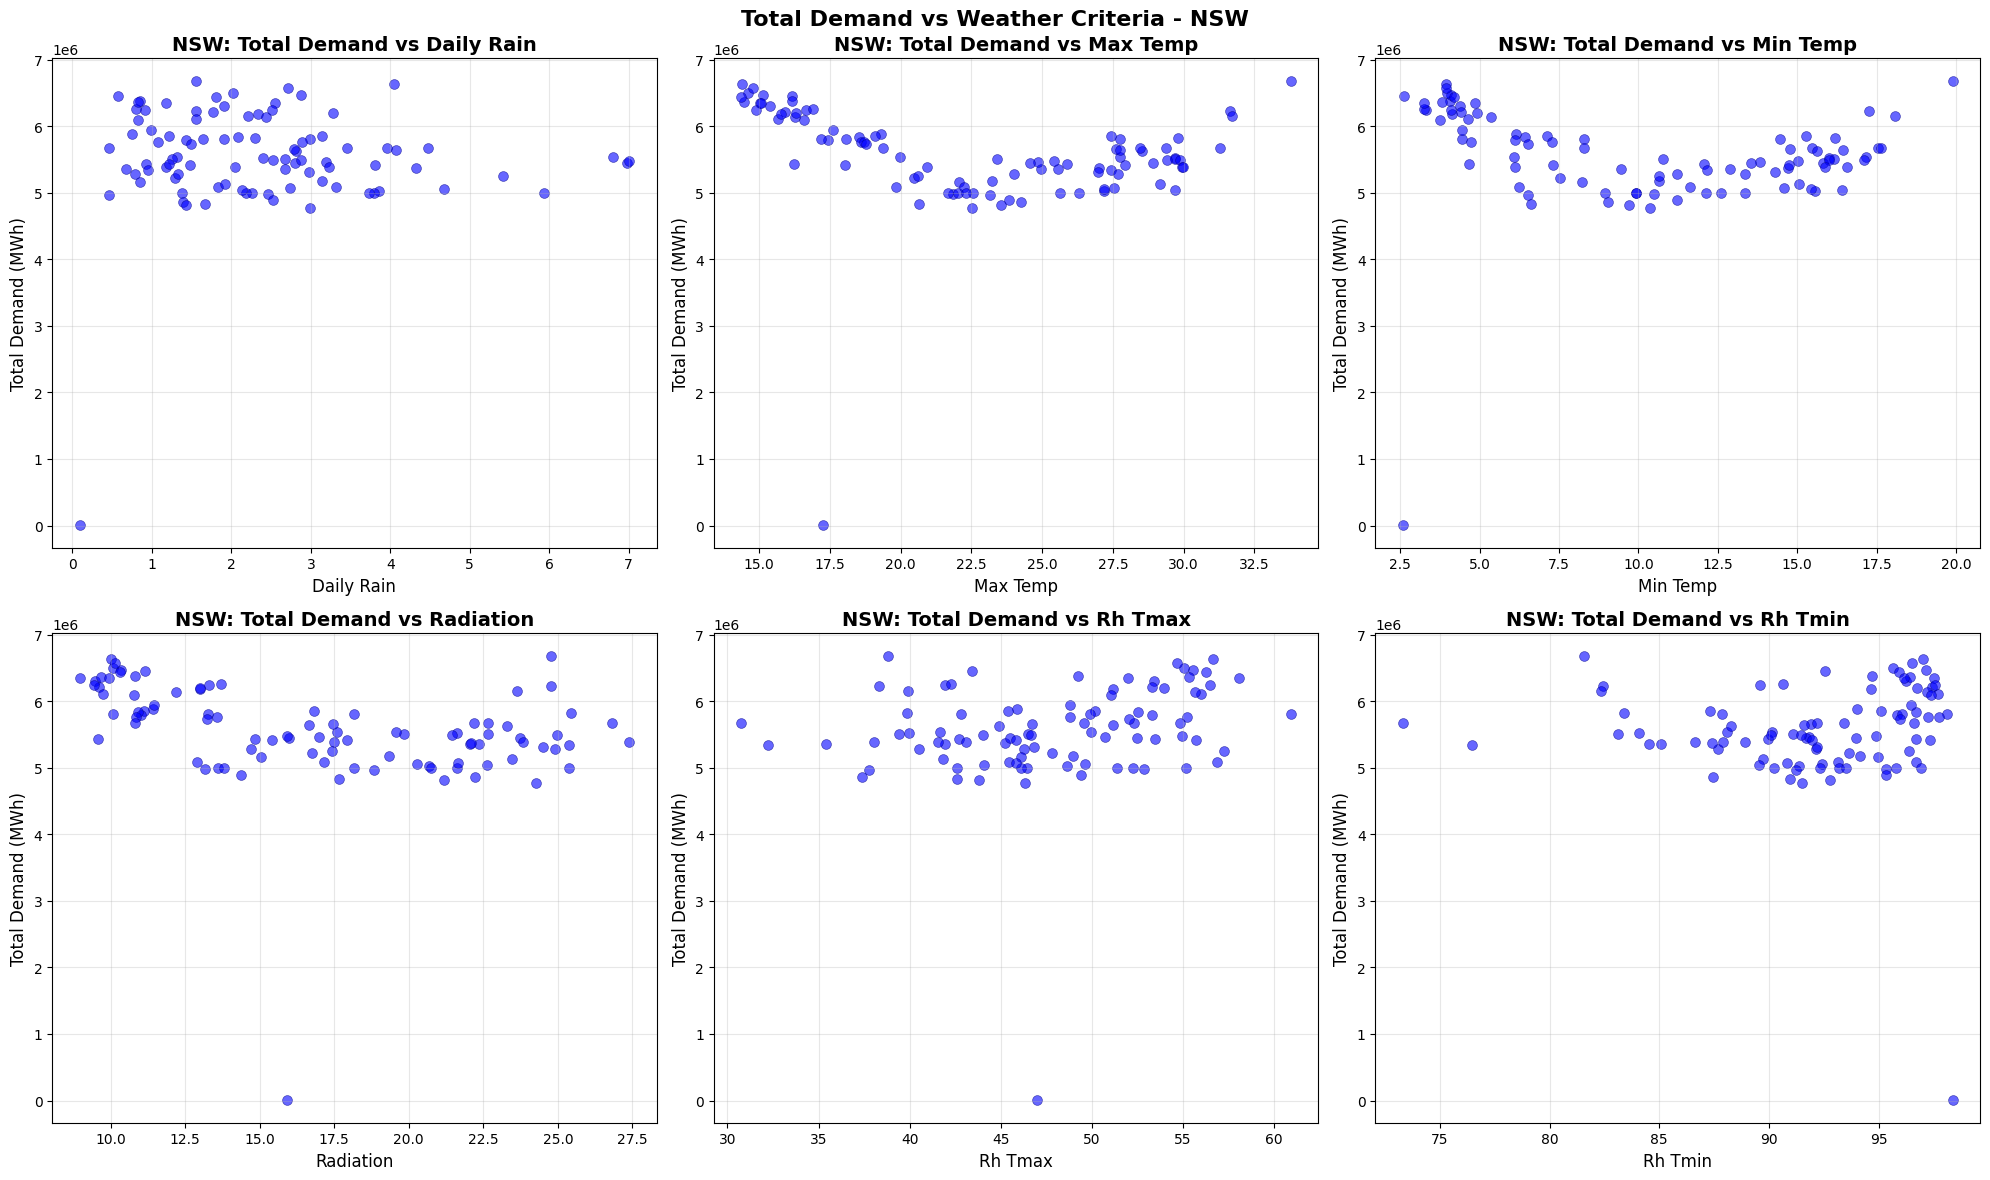

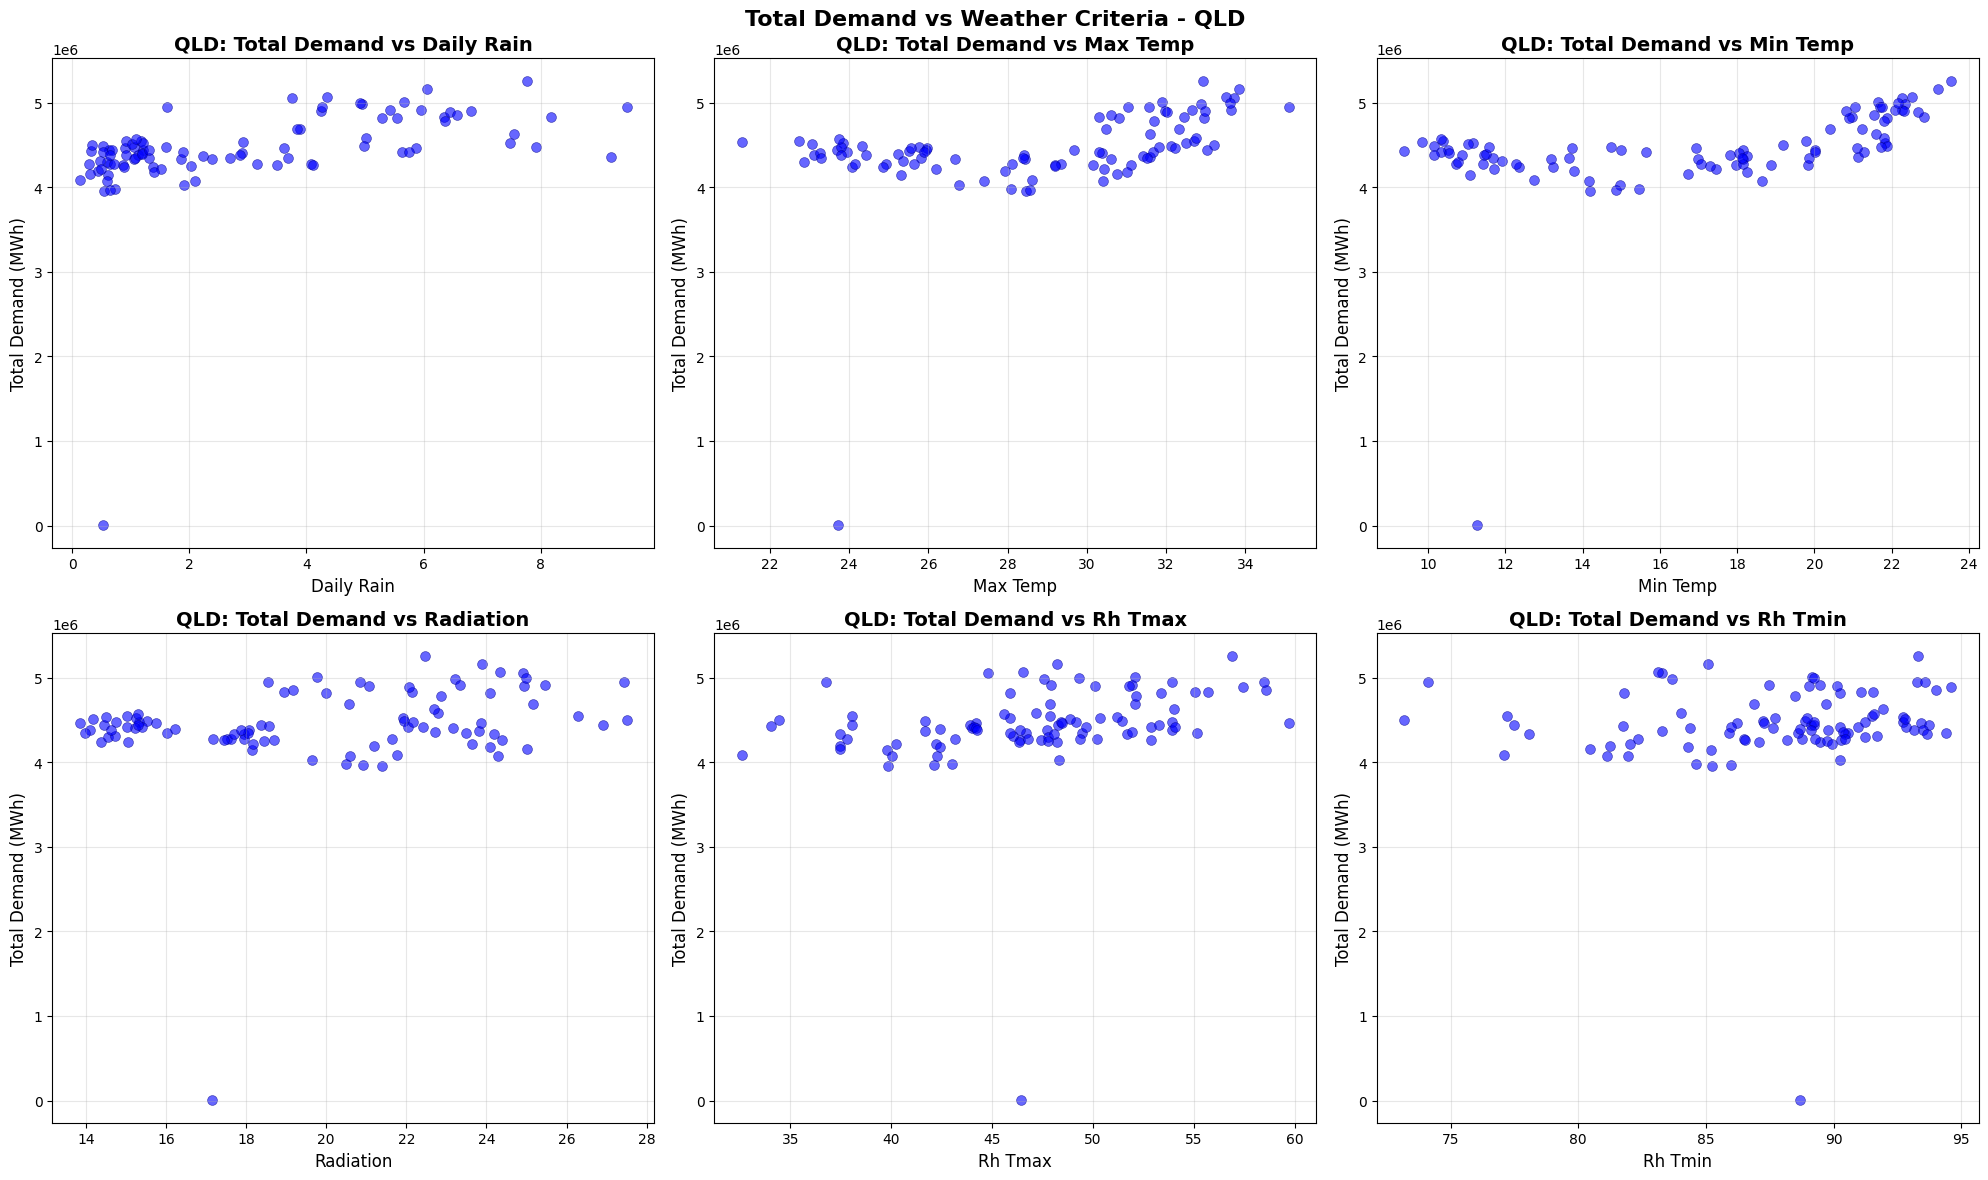

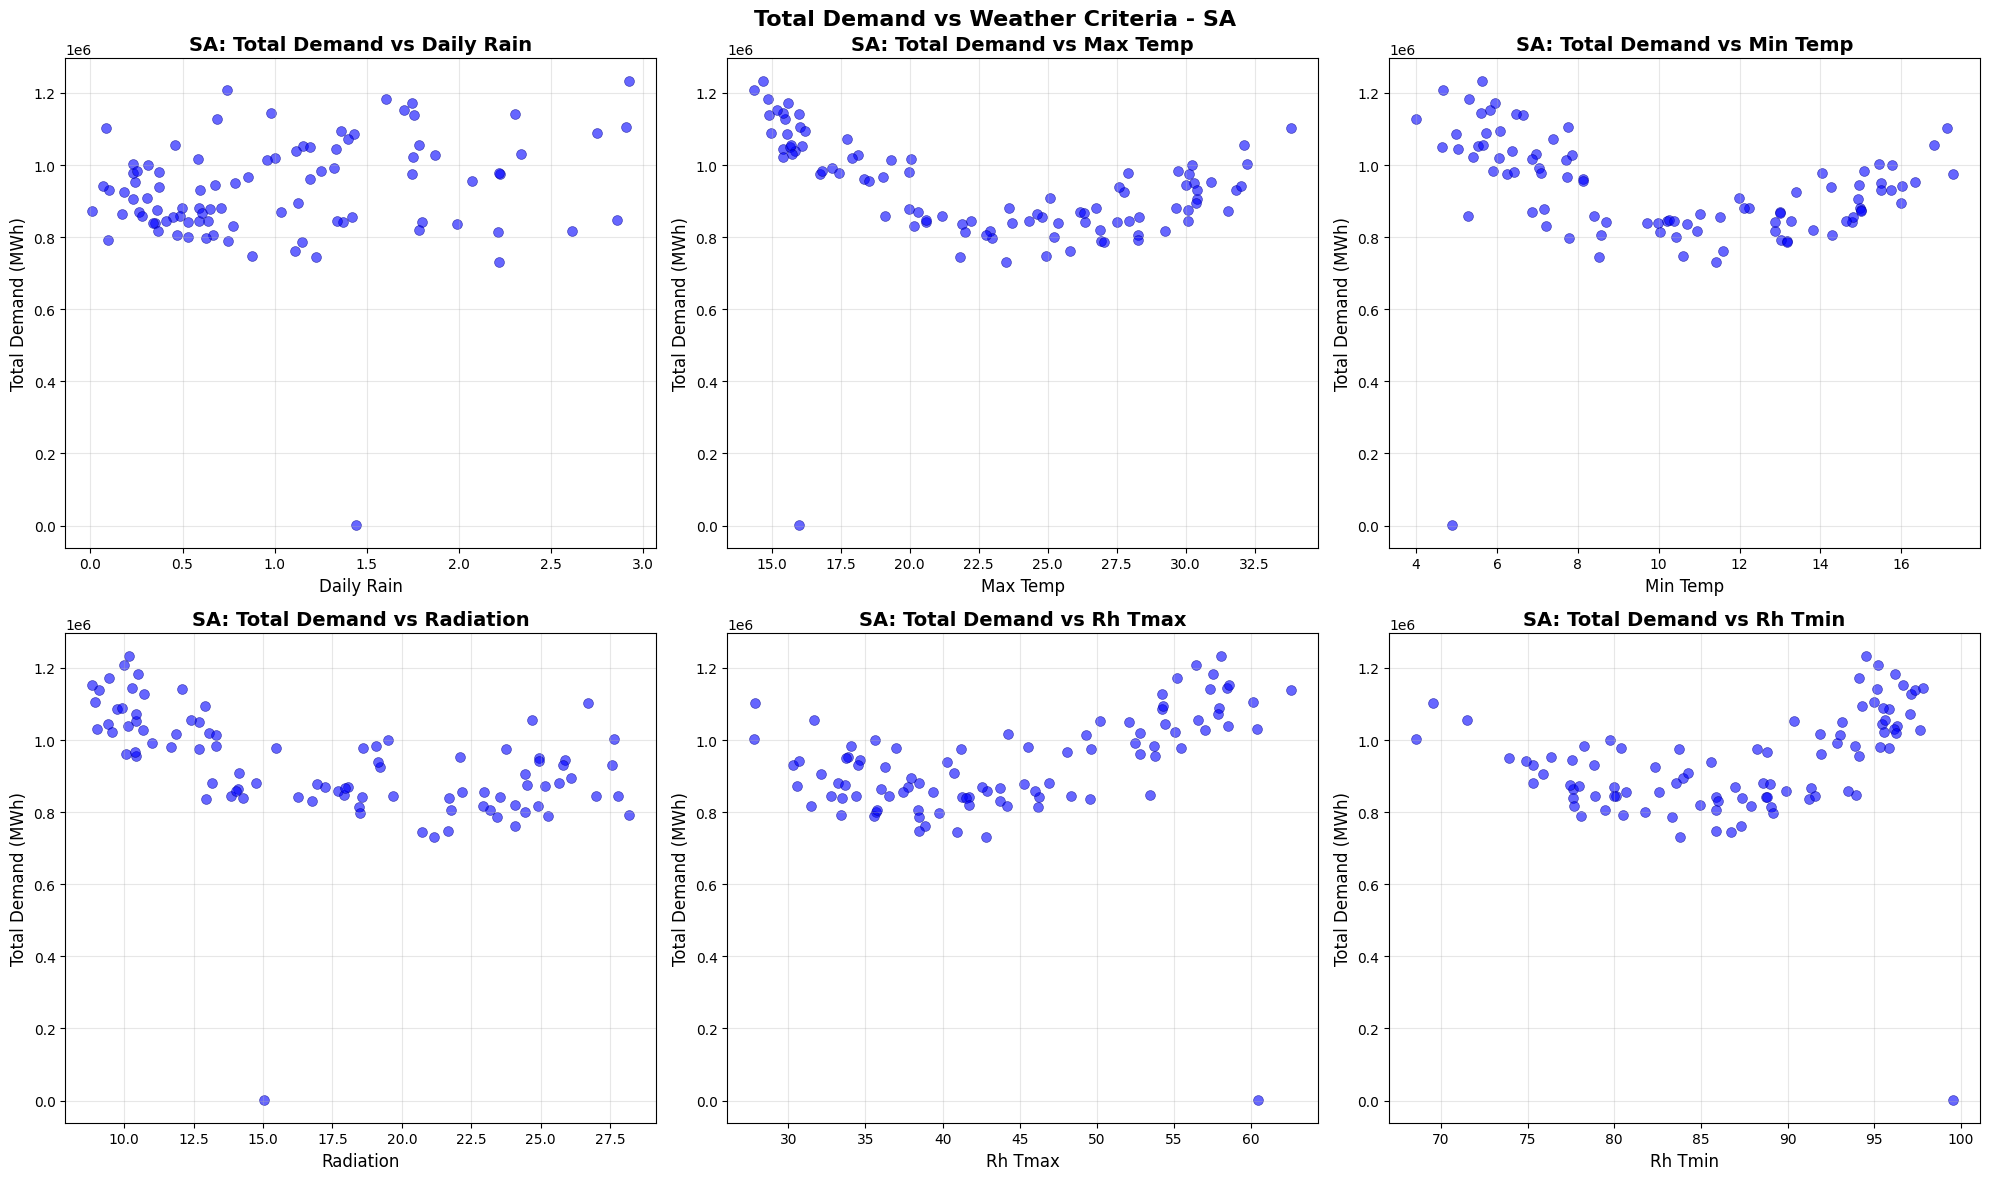

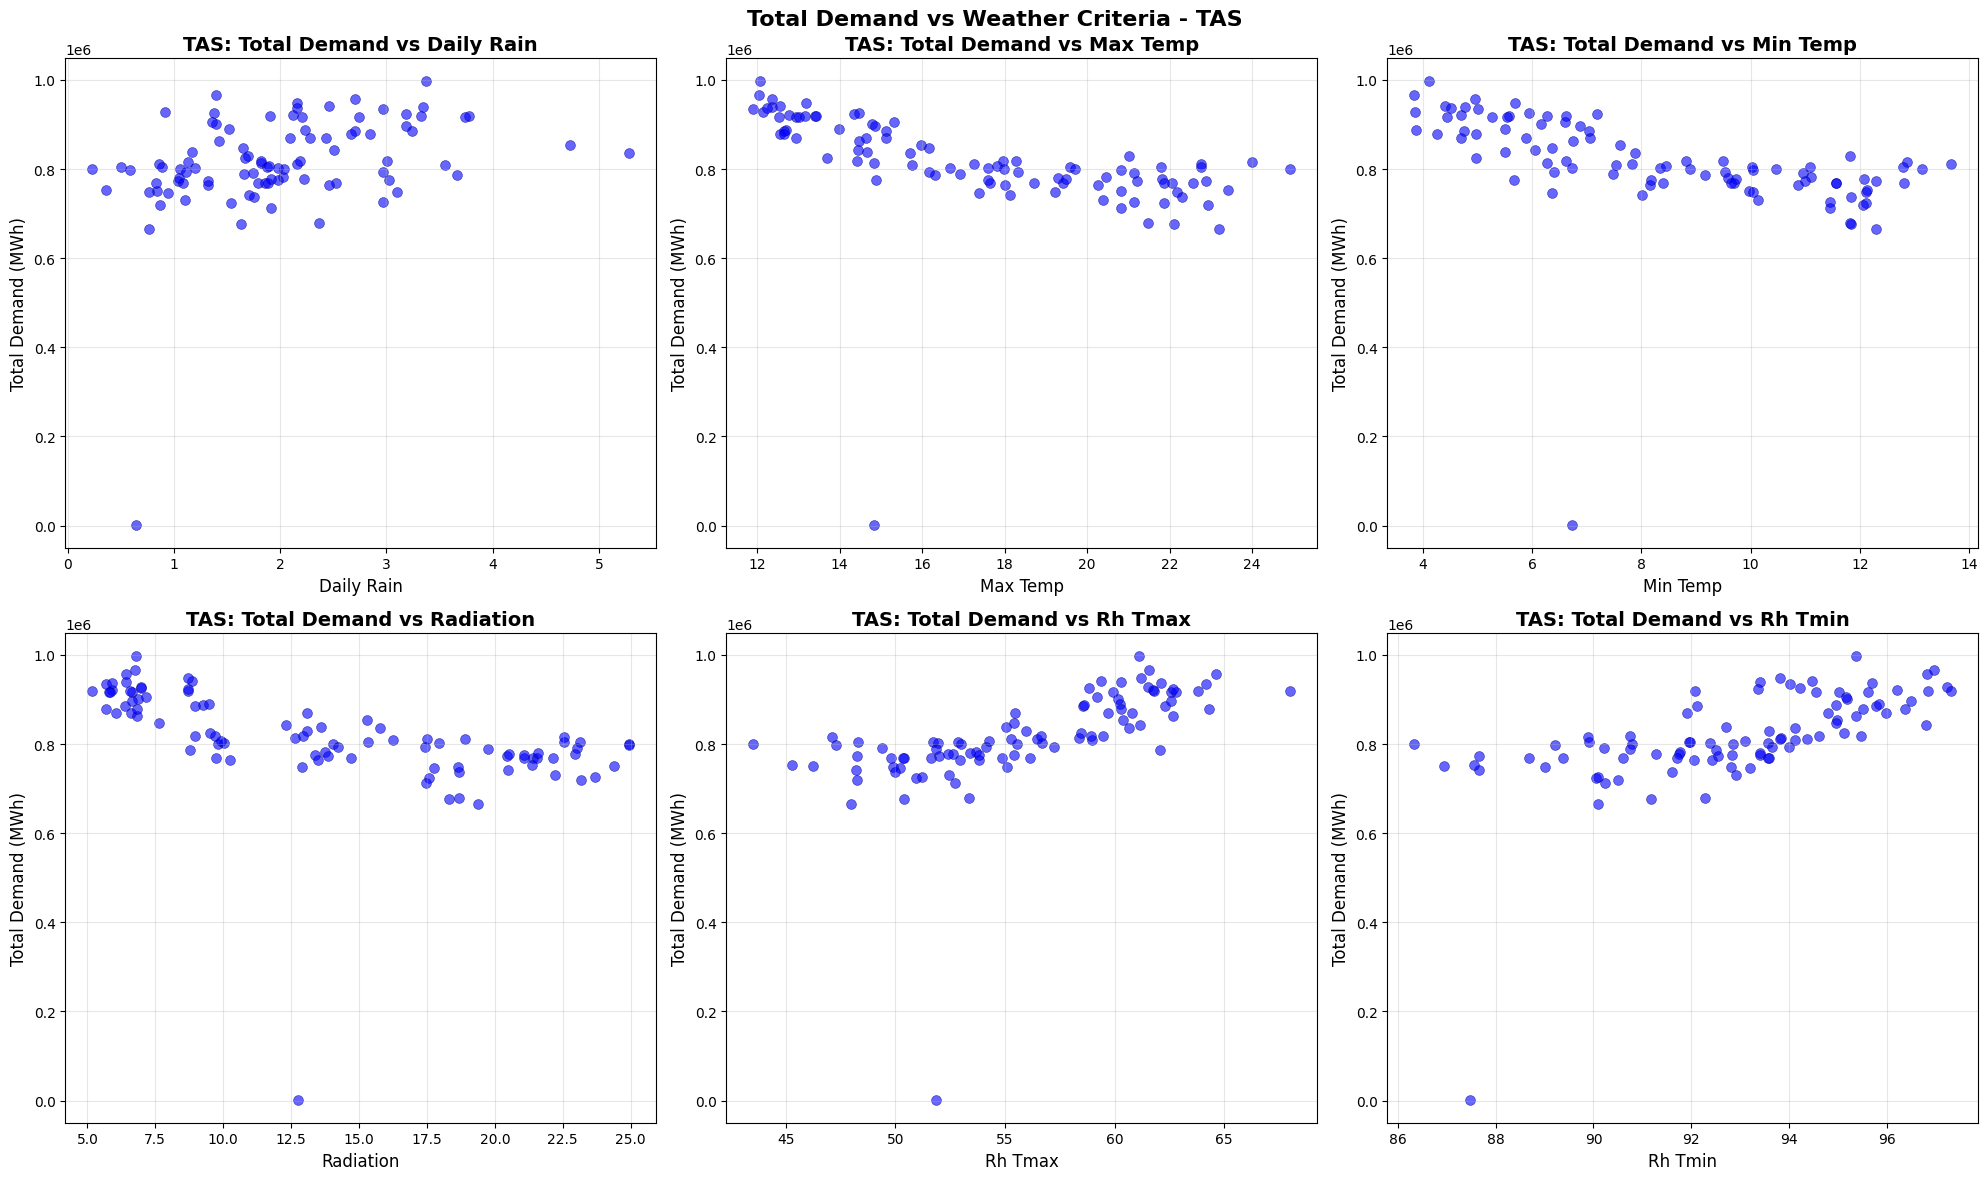

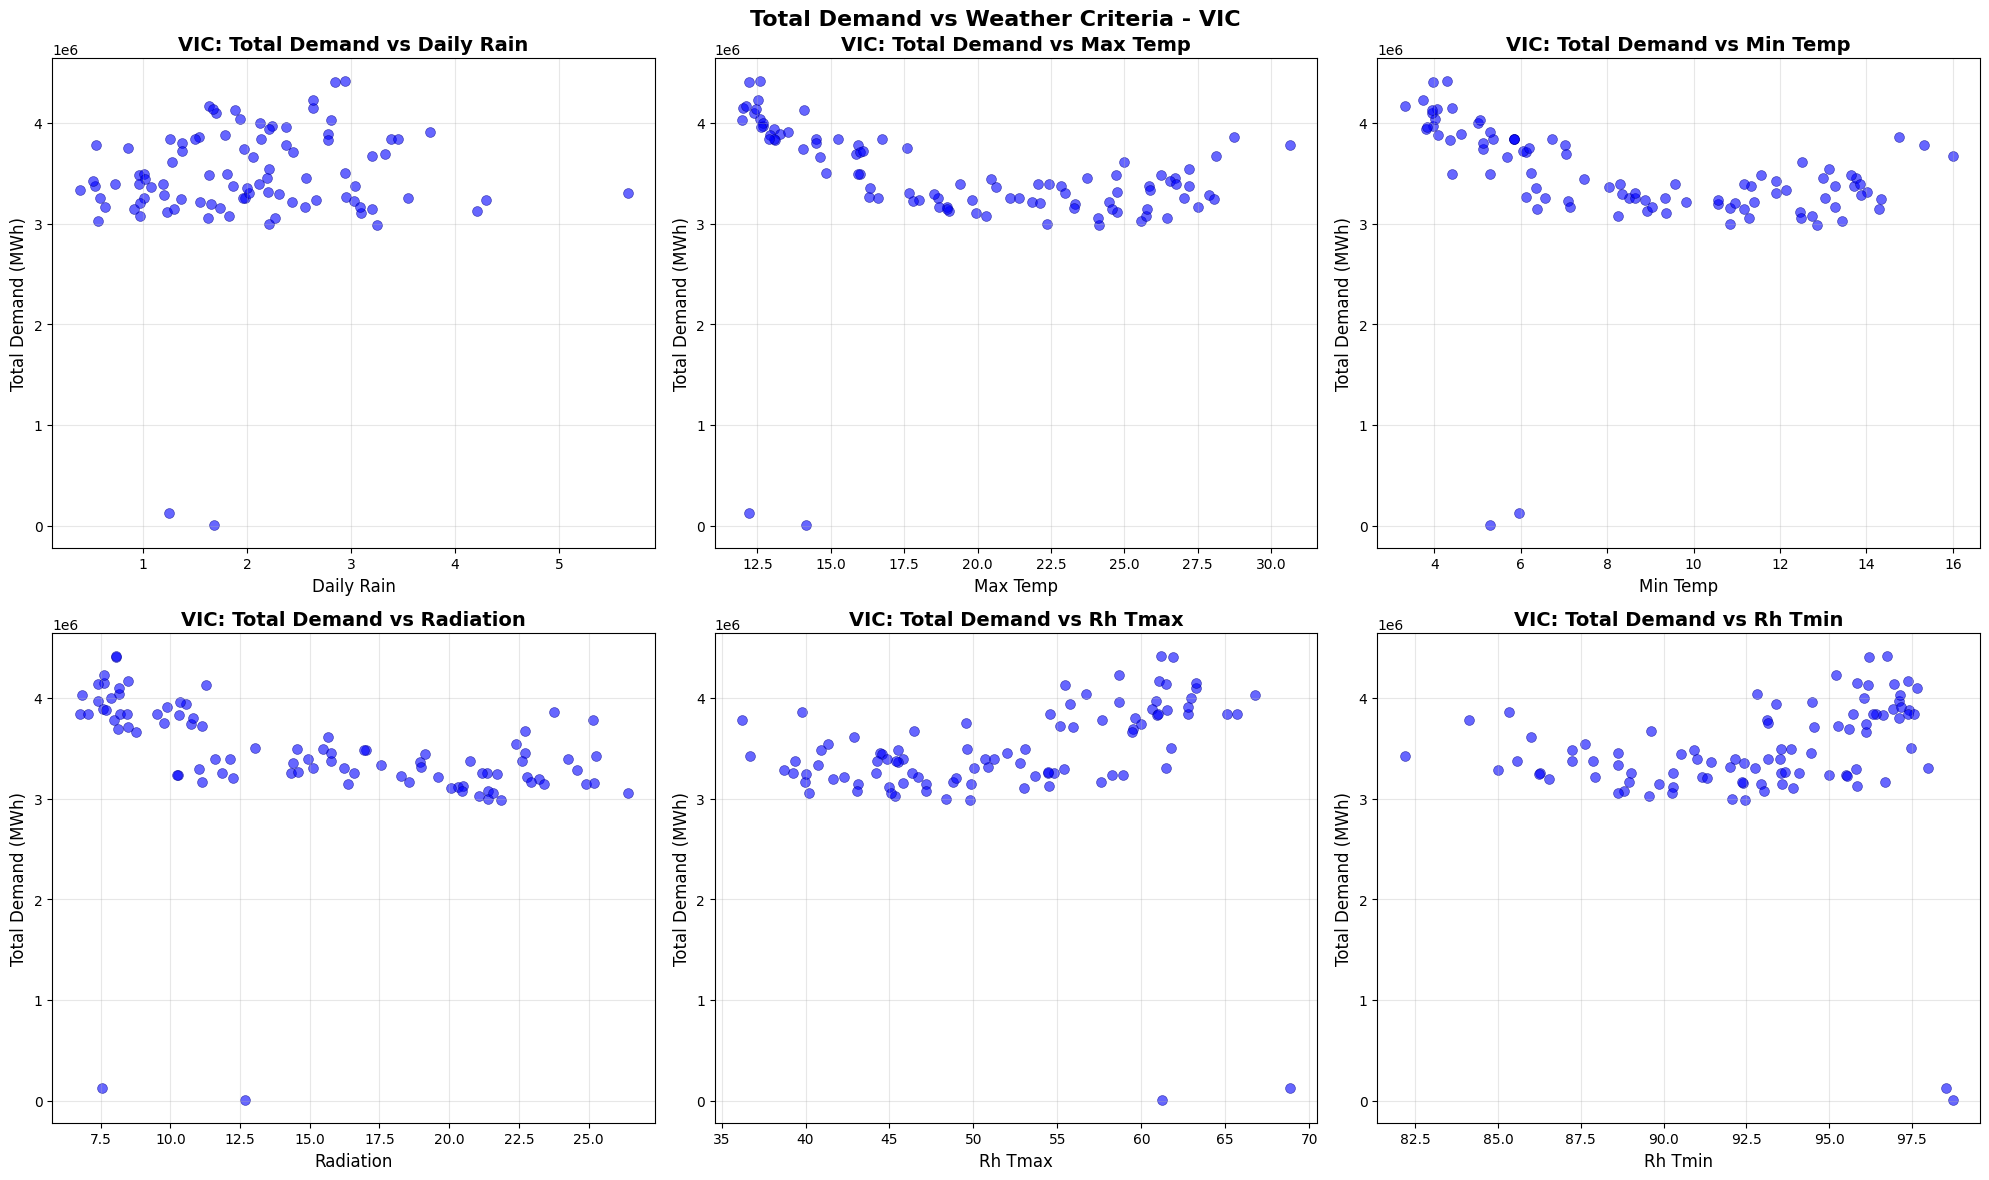

In [12]:
# Create scatter plots showing Total Demand vs each weather criteria for each state separately
if monthly_data is not None:
    weather_criteria = ['daily_rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
    states = sorted(monthly_data['STATE'].unique())
    
    # Create separate plots for each state
    for state in states:
        state_data = monthly_data[monthly_data['STATE'] == state]
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()
        
        for i, criterion in enumerate(weather_criteria):
            ax = axes[i]
            
            # Create scatter plot
            ax.scatter(state_data[criterion], state_data['TOTALDEMAND'], 
                      s=50, color='blue', alpha=0.6, edgecolors='darkblue', linewidth=0.5)
            
            # Formatting
            ax.set_title(f'{state}: Total Demand vs {criterion.replace("_", " ").title()}', 
                        fontsize=14, fontweight='bold')
            ax.set_xlabel(f'{criterion.replace("_", " ").title()}', fontsize=12)
            ax.set_ylabel('Total Demand (MWh)', fontsize=12)
            ax.grid(True, alpha=0.3)
            
            # Format y-axis for better readability
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        
        plt.suptitle(f'Total Demand vs Weather Criteria - {state}', fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
    
else:
    print("✗ Cannot create Total Demand vs Weather Criteria charts - monthly_data is None")


# Train models for predicting electricity demands

In [13]:
# Split data into training, validation, and testing sets
if monthly_data is not None:
    # Convert DATE column to datetime if it's not already
    monthly_data['DATE'] = pd.to_datetime(monthly_data['DATE'])
    
    # Extract year from DATE
    monthly_data['YEAR'] = monthly_data['DATE'].dt.year
    
    # Split data based on years
    # Training: 2018-2022 (5 years)
    # Validation: 2023-2024 (2 years) 
    # Testing: 2025 (1 year)
    
    train_data = monthly_data[monthly_data['YEAR'] <= 2024].copy()
    test_data = monthly_data[monthly_data['YEAR'] == 2025].copy()
    
    print(f"Data split summary:")
    print(f"Training data: {len(train_data)} samples ({train_data['YEAR'].min()}-{train_data['YEAR'].max()})")
    print(f"Testing data: {len(test_data)} samples ({test_data['YEAR'].min()}-{test_data['YEAR'].max()})")
    
else:
    print("✗ Cannot split data - monthly_data is None")


Data split summary:
Training data: 420 samples (2018-2024)
Testing data: 45 samples (2025-2025)


In [14]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [15]:
# Time series prediction with weather features using Cross Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from xgboost import XGBRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

def create_time_series_features(data, target_col='TOTALDEMAND', weather_cols=None):
    """
    Create time series features including lagged values and weather features
    """
    if weather_cols is None:
        weather_cols = ['daily_rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
    
    # Sort by state and date
    data_sorted = data.sort_values(['STATE', 'DATE']).copy()
    
    features_list = []
    
    for state in data_sorted['STATE'].unique():
        state_data = data_sorted[data_sorted['STATE'] == state].copy().reset_index(drop=True)
        
        # Create lagged features (previous months)
        for lag in [1, 2, 3, 6, 12]:
            if len(state_data) > lag:
                state_data[f'{target_col}_lag_{lag}'] = state_data[target_col].shift(lag)
        
        # Create rolling averages
        for window in [3, 6, 12]:
            if len(state_data) > window:
                state_data[f'{target_col}_rolling_{window}'] = state_data[target_col].rolling(window=window).mean()
        
        # Add seasonal features
        state_data['month'] = state_data['DATE'].dt.month
        state_data['quarter'] = state_data['DATE'].dt.quarter
        state_data['year'] = state_data['DATE'].dt.year
        
        # Add weather features (these will be "forecasted" for next month prediction)
        for col in weather_cols:
            if col in state_data.columns:
                # Use current month weather to predict current month demand
                state_data[f'weather_{col}'] = state_data[col]
                
                # Add lagged weather features
                for lag in [1, 2, 3]:
                    if len(state_data) > lag:
                        state_data[f'weather_{col}_lag_{lag}'] = state_data[col].shift(lag)
        
        features_list.append(state_data)
    
    return pd.concat(features_list, ignore_index=True)

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate model performance
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

if train_data is not None and test_data is not None:
    print("🔄 Creating time series features...")
    
    # Combine train and test data for feature engineering
    all_data = pd.concat([train_data, test_data], ignore_index=True)
    
    # Create features
    featured_data = create_time_series_features(all_data)
    
    # Define feature columns (exclude target and non-feature columns)
    exclude_cols = ['TOTALDEMAND', 'DATE', 'STATE', 'YEAR'] + \
                   ['daily_rain', 'max_temp', 'min_temp', 'radiation', 'rh_tmax', 'rh_tmin']
    
    feature_cols = [col for col in featured_data.columns if col not in exclude_cols]
    
    print(f"📊 Created {len(feature_cols)} features:")
    print(f"Features: {feature_cols[:10]}..." if len(feature_cols) > 10 else f"Features: {feature_cols}")
    
    # Split back into train and test
    train_featured = featured_data[featured_data['YEAR'] <= 2024].copy()
    test_featured = featured_data[featured_data['YEAR'] == 2025].copy()
    
    # Remove rows with NaN values (due to lagging)
    train_featured = train_featured.dropna()
    test_featured = test_featured.dropna()
    
    print(f"📈 Training samples after feature engineering: {len(train_featured)}")
    print(f"📈 Testing samples after feature engineering: {len(test_featured)}")
    
    # Prepare features and target
    X_train = train_featured[feature_cols]
    y_train = train_featured['TOTALDEMAND']
    X_test = test_featured[feature_cols]
    y_test = test_featured['TOTALDEMAND']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1),
        'SVR': SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
    }
    
    # Time Series Cross Validation
    print("\n🔄 Performing Time Series Cross Validation...")
    tscv = TimeSeriesSplit(n_splits=5)
    
    cv_results = []
    final_results = []
    
    for model_name, model in models.items():
        print(f"\n📊 Training {model_name}...")
        
        # Cross validation scores
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            # Use scaled features for Linear Regression and SVR
            if model_name in ['Linear Regression', 'SVR']:
                X_train_fold = X_train_scaled[train_idx]
                X_val_fold = X_train_scaled[val_idx]
            else:
                X_train_fold = X_train.iloc[train_idx]
                X_val_fold = X_train.iloc[val_idx]
            
            y_train_fold = y_train.iloc[train_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            # Train model
            model.fit(X_train_fold, y_train_fold)
            
            # Predict
            y_pred_fold = model.predict(X_val_fold)
            
            # Evaluate
            fold_score = evaluate_model(y_val_fold, y_pred_fold, f"{model_name}_fold_{fold+1}")
            cv_scores.append(fold_score)
        
        # Calculate average CV scores
        avg_cv_score = {
            'model': f"{model_name}_CV_avg",
            'MAE': np.mean([score['MAE'] for score in cv_scores]),
            'MSE': np.mean([score['MSE'] for score in cv_scores]),
            'RMSE': np.mean([score['RMSE'] for score in cv_scores]),
            'R2': np.mean([score['R2'] for score in cv_scores])
        }
        cv_results.append(avg_cv_score)
        
        # Train final model on full training data
        if model_name in ['Linear Regression', 'SVR']:
            X_train_final = X_train_scaled
            X_test_final = X_test_scaled
        else:
            X_train_final = X_train
            X_test_final = X_test
        
        model.fit(X_train_final, y_train)
        
        # Predict on test set
        y_pred_test = model.predict(X_test_final)
        
        # Evaluate on test set
        test_score = evaluate_model(y_test, y_pred_test, f"{model_name}_test")
        final_results.append(test_score)
        
        print(f"✅ {model_name} - CV R²: {avg_cv_score['R2']:.4f}, Test R²: {test_score['R2']:.4f}")
    
    # Display results
    print("\n" + "="*80)
    print("📊 CROSS VALIDATION RESULTS")
    print("="*80)
    
    cv_df = pd.DataFrame(cv_results)
    print(cv_df)
    
    print("\n" + "="*80)
    print("📊 FINAL TEST RESULTS")
    print("="*80)
    
    final_df = pd.DataFrame(final_results)
    print(final_df)
    
    # Find best model
    best_model_idx = final_df['R2'].idxmax()
    best_model_name = final_df.loc[best_model_idx, 'model'].replace('_test', '')
    
    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   Test R²: {final_df.loc[best_model_idx, 'R2']:.4f}")
    print(f"   Test RMSE: {final_df.loc[best_model_idx, 'RMSE']:.2f} MWh")
    
else:
    print("✗ Cannot train models - training or testing data is None")


🔄 Creating time series features...
📊 Created 35 features:
Features: ['TOTALDEMAND_lag_1', 'TOTALDEMAND_lag_2', 'TOTALDEMAND_lag_3', 'TOTALDEMAND_lag_6', 'TOTALDEMAND_lag_12', 'TOTALDEMAND_rolling_3', 'TOTALDEMAND_rolling_6', 'TOTALDEMAND_rolling_12', 'month', 'quarter']...
📈 Training samples after feature engineering: 360
📈 Testing samples after feature engineering: 45

🔄 Performing Time Series Cross Validation...

📊 Training Random Forest...
✅ Random Forest - CV R²: -0.0465, Test R²: 0.7385

📊 Training Gradient Boosting...
✅ Gradient Boosting - CV R²: -0.0607, Test R²: 0.7798

📊 Training XGBoost...
✅ XGBoost - CV R²: -1.4506, Test R²: 0.7769

📊 Training SVR...
✅ SVR - CV R²: -175.3603, Test R²: -0.0667

📊 CROSS VALIDATION RESULTS
                      model        MAE              MSE       RMSE      R2
0      Random Forest_CV_avg  621210.05 1495751322232.56  842312.63   -0.05
1  Gradient Boosting_CV_avg  607493.52 1499610301798.17  816277.06   -0.06
2            XGBoost_CV_avg  84407

In [16]:
# Holt-Winters Exponential Smoothing Implementation
print("\n" + "="*80)
print("📈 HOLT-WINTERS EXPONENTIAL SMOOTHING")
print("="*80)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

if X_train is not None and y_train is not None:
    try:
        # Prepare time series data for Holt-Winters
        # Combine training data with dates for time series analysis
        train_ts = pd.Series(y_train.values, index=pd.date_range(start='2018-01-01', periods=len(y_train), freq='D'))
        
        # Fit Holt-Winters model with different configurations
        hw_models = {
            'Additive': {'seasonal': 'add', 'seasonal_periods': 365},
            'Multiplicative': {'seasonal': 'mul', 'seasonal_periods': 365},
            'No Seasonal': {'seasonal': None}
        }
        
        hw_results = []
        
        for hw_name, hw_params in hw_models.items():
            print(f"\n🔄 Training Holt-Winters ({hw_name})...")
            
            try:
                # Fit the model
                hw_model = ExponentialSmoothing(
                    train_ts,
                    trend='add',
                    **hw_params
                ).fit(optimized=True)
                
                # Forecast for test period
                forecast_steps = len(y_test)
                hw_forecast = hw_model.forecast(steps=forecast_steps)
                
                # Evaluate predictions
                hw_score = evaluate_model(y_test, hw_forecast.values, f"Holt-Winters_{hw_name}")
                hw_results.append(hw_score)
                
                print(f"✅ Holt-Winters ({hw_name}) - Test R²: {hw_score['R2']:.4f}, RMSE: {hw_score['RMSE']:.2f} MWh")
                
            except Exception as e:
                print(f"❌ Holt-Winters ({hw_name}) failed: {str(e)}")
                continue
        
        # Display Holt-Winters results
        if hw_results:
            print("\n" + "="*80)
            print("📊 HOLT-WINTERS RESULTS")
            print("="*80)
            
            hw_df = pd.DataFrame(hw_results)
            print(hw_df)
            
            # Find best Holt-Winters model
            best_hw_idx = hw_df['R2'].idxmax()
            best_hw_name = hw_df.loc[best_hw_idx, 'model']
            
            print(f"\n🏆 Best Holt-Winters model: {best_hw_name}")
            print(f"   Test R²: {hw_df.loc[best_hw_idx, 'R2']:.4f}")
            print(f"   Test RMSE: {hw_df.loc[best_hw_idx, 'RMSE']:.2f} MWh")
            
            # Compare with previous best model
            if 'final_df' in locals():
                print(f"\n📈 Comparison with best ML model ({best_model_name}):")
                print(f"   ML Model R²: {final_df.loc[best_model_idx, 'R2']:.4f}")
                print(f"   Holt-Winters R²: {hw_df.loc[best_hw_idx, 'R2']:.4f}")
                
                if hw_df.loc[best_hw_idx, 'R2'] > final_df.loc[best_model_idx, 'R2']:
                    print("   🎯 Holt-Winters performs better!")
                else:
                    print("   🎯 ML model performs better!")
        
    except Exception as e:
        print(f"❌ Holt-Winters implementation failed: {str(e)}")
        
else:
    print("✗ Cannot implement Holt-Winters - training or testing data is None")



📈 HOLT-WINTERS EXPONENTIAL SMOOTHING

🔄 Training Holt-Winters (Additive)...
❌ Holt-Winters (Additive) failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

🔄 Training Holt-Winters (Multiplicative)...
❌ Holt-Winters (Multiplicative) failed: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

🔄 Training Holt-Winters (No Seasonal)...
✅ Holt-Winters (No Seasonal) - Test R²: 0.0699, RMSE: 2040140.61 MWh

📊 HOLT-WINTERS RESULTS
                      model        MAE              MSE       RMSE   R2
0  Holt-Winters_No Seasonal 1871810.68 4162173698677.60 2040140.61 0.07

🏆 Best Holt-Winters model: Holt-Winters_No Seasonal
   Test R²: 0.0699
   Test RMSE: 2040140.61 MWh

📈 Comparison with best ML model (Gradient Boosting):
   ML Model R²: 0.7798
   Holt-Winters R²: 0.0699
   🎯 ML model performs better!
